## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optilibrary as libopt

In [2]:
from scipy.linalg import norm

In [3]:
X_train, y_train, X_test, y_test = libopt.importData(p=0.2)
n, d = X_train.shape
print(X_train.shape)
lbda = 1. / n ** (0.5)

(16512, 9)


In [4]:
#Create models using data
pblinreg = libopt.RegPb(X_train, y_train, lbda, loss='l2')

In [5]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(d)
# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))

0.20441741636810176
3.642471005074279e-09


## Question 1: 
- Implement stochastic gradient and 

In [6]:
from optilibrary import stoch_grad

- compare its performance with that of your gradient descent implementation from Part 1 on the same problem and dataset. 
- What happens when both methods are run using the same stepsize? 
- Do your observations confirm what has been discussed during the lecture?

We consider the same dataset as in Part 1 and compare the performance of the stochastic descent and gradient descent technques. To ensure comparability, the following parameters are fixed:
- Number of epochs (eg. number of accesses to the gradient) is set to 30
- $x_0$ the initial estimate is set to **0**$\in\mathbb{R}^d$.

As the SG method is not always guaranteed to converge, we opt to compare the methods by making use of a decreasing step size.
- The step parameter is fixed to $\frac{1}{\sqrt{k+1}}$ at iteration $k$.

In [7]:
nb_epochs = 50
x0 = np.zeros(d)

import time
elapsed = []

x = []; obj=[]; its=[]
batches = [1, int(n/500), int(n/100), int(n/10), int(n/2), n]
btitle = ['1', 'n/500', 'n/100', 'n/10', 'n/2', 'n']

for i in range(len(batches)):
    nbset = batches[i]
    print(f'niter={int((nb_epochs*n)/nbset)}, nb={nbset}')
    st = time.time()
    x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int((nb_epochs*n)/nbset),nb=nbset)
    et = time.time()
    elapsed.append(et-st)
    x.append(x_a)
    obj.append(obj_a)
    its.append(nits_a)
    
#To even out
obj = np.array([np.array(o[-nb_epochs-1:-1]) for o in obj])
obj.shape

niter=825600, nb=1
Epoch 50
niter=25018, nb=33
Epoch 49
niter=5003, nb=165
Epoch 49
niter=500, nb=1651
Epoch 49
niter=100, nb=8256
Epoch 50
niter=50, nb=16512
Epoch 50


(6, 50)

Plot

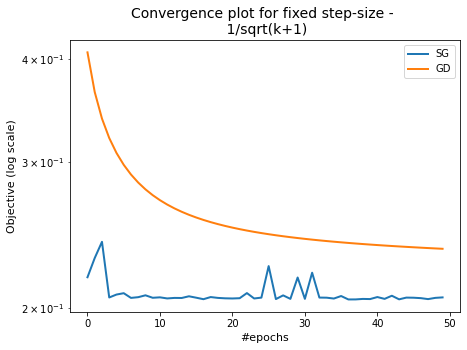

In [8]:
plt.figure(figsize=(7, 5))
plt.semilogy(obj[0], lw=2)
plt.semilogy(obj[-1], lw=2)
plt.title("Convergence plot for fixed step-size - \n 1/sqrt(k+1)", fontsize=14)
plt.xlabel("#epochs", fontsize=11)
plt.ylabel("Objective (log scale)", fontsize=11)
plt.legend(('SG', 'GD'));

This run beautifully illustrates typical characteristics of the 2 algorithms when compared one to the other:

As discussed in class, the stochastic gradient algorithm is not a descent method; behaviour which is clearly observed here in that the objective value is sometimes increasing over successive epochs. The oscillatory phase following a phase of quick descent corresponds to class discussion in that we observe the method stalling when the steps get too small to make a big improvment.

Conversely, gradient descent is guaranteed to descend over every successive iteration and we observe this behaviour clearly below.

For this method, and for a fixed number of epochs, it seems that SG performs better than the method from which it was derived.



## Question 2: 
Find a value for the batch size that realizes a good compromise between gradient descent and stochastic gradient.

We consider several different batch sizes, each for a fixed number of epochs and compare this to the gradient descent method (where the batch size is merely $n$, the number of entries).

$$\text{\#batch} = \left\{1, \frac{n}{100}, \frac{n}{10}, \frac{n}{5}, n \right\}$$

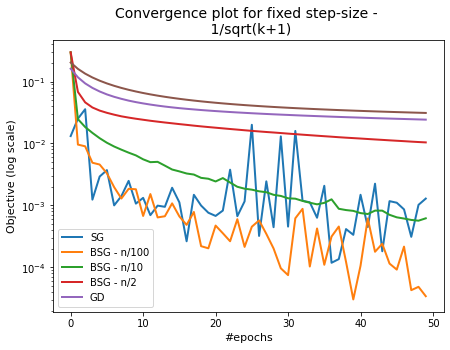

In [9]:
# Plot the comparison of variants of batch SGD with the same stepsize rule
plt.figure(figsize=(7, 5))
for i in range(len(batches)):
    plt.semilogy(obj[i]-f_min_lin, lw=2)
plt.title("Convergence plot for fixed step-size - \n 1/sqrt(k+1)", fontsize=14)
plt.xlabel("#epochs", fontsize=11)
plt.ylabel("Objective (log scale)", fontsize=11)

plt.legend(['SG', 'BSG - n/100', 'BSG - n/10', 'BSG - n/2', 'GD']);


[0.20570614 0.20445165 0.20503653 0.21481876 0.22866067 0.235512  ]


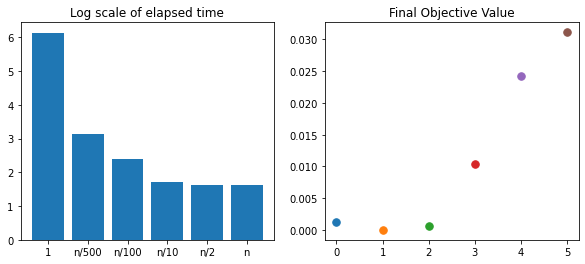

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.bar(btitle, np.log(elapsed))
plt.title('Log scale of elapsed time')

plt.subplot(1,2,2)
for i in range(len(obj)):
    plt.plot(i, obj[i][-1]-f_min_lin, '.-', markersize=15)

plt.title('Final Objective Value');
print(obj[:,-1])

BSG with n/100 seems to perform almost exactly as well as vanilla SG, but with a runtime comparable to smaller batch size. We conclude that batch stochastic gradient with a batch size of n/100 would be satisfactory. 

## *Question 3:* 

Compare your stochastic gradient method with one of the advanced variants seen in class on your selected problem. Discuss your results, and what interpretation you can draw from them.

We consider SG and compare it with averaging.
(Only 5 reps because big dataset)

In [11]:
# Comparison of stochastic gradient with and without averaging
nb_epochs = 50
x0 = np.zeros(d)

nruns = 5

obj_a = []
obj_b = []
obj_c = []

nbset = int(n/1000)
niter=int(nb_epochs*n/nbset)

for i in range(nruns):
    # Run standard stochastic gradient without averaging
    _, oa, _ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=niter, nb=nbset)
    obj_a.append(oa)
    # Run stochastic gradient with averaging
    _, ob, _= stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=niter, nb=nbset,average=1)
    obj_b.append(ob)
    # # Stochastic gradient (batch size 1) with RMSProp diagonal scaling
    # _, oc,_ = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=1,step0=0.2, n_iter=niter,nb=nbset,average=0,scaling=1)
    # obj_c.append(oc)


Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50
Epoch 50


In [12]:
obj_a = np.array(obj_a)
obj_b = np.array(obj_b)
obj_c = np.array(obj_c)

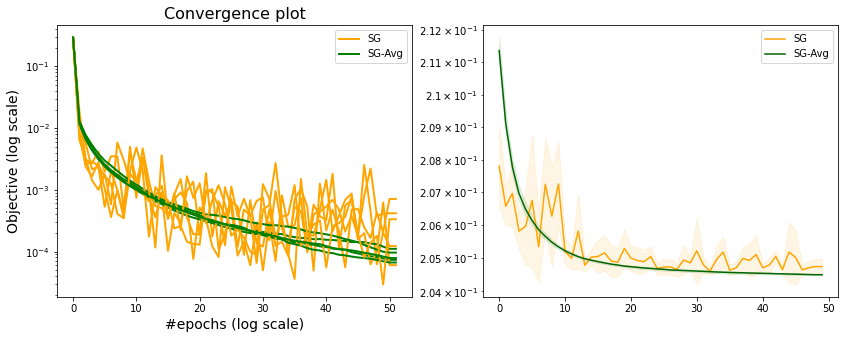

In [13]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
for i in range(nruns):
    plt.semilogy(obj_a[i]-f_min_lin,color='orange',lw=2)
    plt.semilogy(obj_b[i]-f_min_lin,color='g', lw=2)
    # plt.semilogy(obj_c[i]-f_min_lin,color='indianred', lw=2)

plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(('SG', 'SG-Avg'))

plt.subplot(1,2,2)
t = np.arange(nb_epochs)
ma = np.mean(obj_a[:,2:], axis=0)
sda = np.std(obj_a[:,2:], axis=0)
plt.plot(t, ma, 'orange')
plt.fill_between(t, ma - sda, ma + sda, color='orange', alpha=0.1)

mb = np.mean(obj_b[:,2:], axis=0)
sdb = np.std(obj_b[:,2:], axis=0)
plt.plot(t, mb, 'darkgreen')
plt.fill_between(t, mb - sdb, mb + sdb, color='g', alpha=0.1)

plt.yscale('log')
plt.yticks([])
plt.legend(('SG', 'SG-Avg'));

As mentioned above, SG is not a descent method and so not guaranteed to descend at each iteration. It will, however, descend on average. By averaging over iterates, one is essentially enforcing the 'descent' behaviour of SGD. Moreover, averaging will also decrease variance in the method. 